In [2]:
from keras.layers import InputLayer, Flatten, Dense, Reshape, Input, Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import Sequential
from keras.models import Model

In [3]:
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt

In [4]:
files = []
for r, d, f in os.walk('./emojies_face/'):
    for file in f:
            files.append(os.path.join(r, file))

dataset = np.zeros((len(files),72,72,4))
for i in range(0, len(files)):
    file = files[i]
    image = imageio.imread(file)
    if image.shape == (72,72,4):
        dataset[i] = image
print("Dataset shape is", dataset.shape)

Dataset shape is (114, 72, 72, 4)


In [5]:
dataset = dataset.astype('float32') / 255

In [6]:
image_shape = (72,72,4)
encoding_dim = 1

In [7]:
def build_simple_autoencoder():
    encoder_input = Input(shape=image_shape)
    encoder_1 = Flatten()(encoder_input)
    encoder_2 = Dense(units=encoding_dim*3, activation="relu")(encoder_1)
    encoder_3 = Dense(units=encoding_dim*2, activation="relu")(encoder_2)
    encoder_4 = Dense(units=encoding_dim, activation="linear")(encoder_3)
    
    encoder = Model(encoder_input, encoder_4, name="encoder")

    decoder_input = Input(shape=(encoding_dim,))
    decoder_1 = Dense(units=encoding_dim*2, activation='relu')(decoder_input)
    decoder_2 = Dense(units=encoding_dim*3, activation='relu')(decoder_1)
    decoder_3 = Dense(units=72*72*4, activation='sigmoid')(decoder_2)
    decoder_4 = Reshape(target_shape=image_shape)(decoder_3)
    
    decoder = Model(decoder_input, decoder_4, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [107]:
def build_dens_autoencoder():
    
    encoder_input = Input(shape=image_shape)
    encoder_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder_input)
    encoder_layer = MaxPooling2D((3, 3), padding='same')(encoder_layer)
    encoder_layer = Dropout(0.1)(encoder_layer)
    encoder_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_layer)
    encoder_layer = MaxPooling2D((3, 3), padding='same')(encoder_layer)
    encoder_layer = Dropout(0.1)(encoder_layer)
    encoder_layer = Conv2D(32, (4, 4), activation='relu', padding='same')(encoder_layer)
    encoder_layer = MaxPooling2D((4, 4), padding='same')(encoder_layer)
    encoder_layer = Dropout(0.1)(encoder_layer)
    encoder_layer = Conv2D(64, (2, 2), activation='relu', padding='same')(encoder_layer)
    encoder_layer = MaxPooling2D((2, 2), padding='same')(encoder_layer)
    encoder_layer = Dropout(0.1)(encoder_layer)
    encoder_layer = Reshape(target_shape=(64,))(encoder_layer)
    encoder = Model(encoder_input, encoder_layer, name="encoder")


    decoder_input = Input(shape=(64,))
    decoder_layer = Reshape(target_shape=(1,1,64))(decoder_input)
    decoder_layer = Conv2D(64, (2, 2), activation='relu', padding='same')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)
    decoder_layer = Dropout(0.1)(decoder_layer)
    decoder_layer = Conv2D(32, (4, 4), activation='relu', padding='same')(decoder_layer)
    decoder_layer = UpSampling2D((4, 4))(decoder_layer)
    decoder_layer = Dropout(0.1)(decoder_layer)
    decoder_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder_layer)
    decoder_layer = UpSampling2D((3, 3))(decoder_layer)
    decoder_layer = Dropout(0.1)(decoder_layer)
    decoder_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_layer)
    decoder_layer = UpSampling2D((3, 3))(decoder_layer)
    decoder_layer = Dropout(0.1)(decoder_layer)
    decoder_layer = Conv2D(4, (4, 4), activation='sigmoid', padding='same')(decoder_layer)
    decoder = Model(decoder_input, decoder_layer, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [195]:
def build_dens_autoencoder_2():
    
    encoder_input = Input(shape=image_shape)
    encoder_layer = Conv2D(128, (2, 2), activation='relu', padding='same')(encoder_input)
    encoder_layer = MaxPooling2D((2, 2), padding='same')(encoder_layer)
    encoder_layer = Dropout(0.1)(encoder_layer)
    encoder = Model(encoder_input, encoder_layer, name="encoder")

    decoder_input = Input(shape=(36,36,128))
    decoder_layer = UpSampling2D((2, 2))(decoder_input)
    decoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same')(decoder_layer)
    decoder_layer = Dropout(0.1)(decoder_layer)
    decoder = Model(decoder_input, decoder_layer, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [196]:
# encoder, decoder, autoencoder = build_simple_autoencoder()
# encoder, decoder, autoencoder = build_dens_autoencoder()
encoder, decoder, autoencoder = build_dens_autoencoder_2()

In [197]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 72, 72, 4)         0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 72, 72, 128)       2176      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 36, 36, 128)       0         
Total params: 2,176
Trainable params: 2,176
Non-trainable params: 0
_________________________________________________________________


In [198]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 36, 36, 128)       0         
_________________________________________________________________
up_sampling2d_36 (UpSampling (None, 72, 72, 128)       0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 72, 72, 4)         2052      
_________________________________________________________________
dropout_31 (Dropout)         (None, 72, 72, 4)         0         
Total params: 2,052
Trainable params: 2,052
Non-trainable params: 0
_________________________________________________________________


In [199]:
autoencoder.fit(dataset, dataset,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(dataset, dataset))

Train on 114 samples, validate on 114 samples
Epoch 1/100
114/114 [==============================] - 3s 28ms/step - loss: 5.9141 - val_loss: 3.9726
Epoch 2/100
114/114 [==============================] - 2s 20ms/step - loss: 4.2179 - val_loss: 3.3228
Epoch 3/100
114/114 [==============================] - 2s 20ms/step - loss: 3.3534 - val_loss: 0.9956
Epoch 4/100
114/114 [==============================] - 2s 20ms/step - loss: 1.5994 - val_loss: 0.5103
Epoch 5/100
114/114 [==============================] - 2s 20ms/step - loss: 1.2228 - val_loss: 0.4282
Epoch 6/100
114/114 [==============================] - 2s 20ms/step - loss: 1.1867 - val_loss: 0.4070
Epoch 7/100
114/114 [==============================] - 2s 20ms/step - loss: 1.2123 - val_loss: 0.4023
Epoch 8/100
114/114 [==============================] - 2s 21ms/step - loss: 1.2370 - val_loss: 0.3963
Epoch 9/100
114/114 [==============================] - 2s 20ms/step - loss: 1.2238 - val_loss: 0.3877
Epoch 10/100
114/114 [==============

KeyboardInterrupt: 

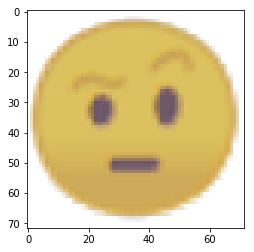

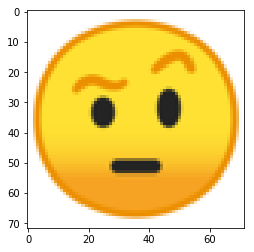

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


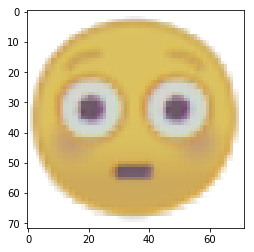

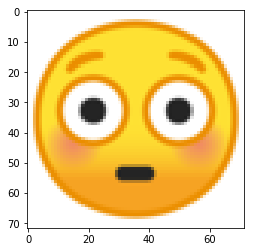

In [200]:
i = 15
imgs = dataset[i:i+2]
predicted_imgs = autoencoder.predict(imgs, batch_size=1)
for ind in range(0,len(imgs)):
    plt.imshow(predicted_imgs[ind])
    plt.show()
    plt.imshow(imgs[ind])
    plt.show()

In [113]:
imgs = dataset[2:3]
encoded_imgs = encoder.predict(imgs)
for encoded_img in encoded_imgs:
    print(encoded_img.shape)
    print(encoded_img)
#     print(encoded_img)
#     plt.imshow(encoded_img)
#     plt.show()

(64,)
[0.6725303  0.16323882 0.16535547 0.01421279 0.41812637 0.23827481
 0.8472099  0.35966507 0.36247233 0.23535909 0.7915775  0.4004071
 0.22255722 0.43660155 0.         0.         0.5900263  0.34240845
 0.5321973  0.61913157 0.90163946 0.8531403  0.         0.6183898
 0.17754051 0.28062293 0.30461907 0.259604   0.88820106 0.27031153
 0.18284707 0.5091822  0.34132582 0.3539363  0.3542509  0.
 0.64107853 0.48262405 0.10630474 0.5030567  0.6487922  0.6577711
 0.22946313 0.7853135  0.33918145 0.54438126 0.7689995  0.22283992
 0.3305272  0.2368011  0.16905643 0.8162522  0.43705288 0.07088291
 0.17668211 0.2649738  0.293778   0.         0.21791163 0.1699809
 0.15645184 0.0520307  0.         0.4447547 ]


In [47]:
encoded_imgs[0,0,5] = 5.0
decoded_imgs = decoder.predict(encoded_imgs, batch_size=1)
for decoded_img in decoded_imgs:
    print(decoded_img.shape)
    plt.imshow(decoded_img)
    plt.show()

IndexError: too many indices for array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


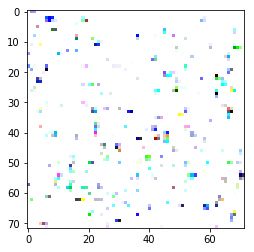

In [211]:
seeds = np.random.uniform(low=0.0, high=2.0, size=(1,36,36,128))
# seeds = np.random.normal(loc=0.5, scale=1.0, size=(1,64))
# seeds = np.random.beta(a=0.6, b=1.2, size=(1,encoding_dim))
# seeds = np.zeros((1,18,18,1))
generated_imgs = decoder.predict(seeds, batch_size=1)
for generated_img in generated_imgs:
    plt.imshow(generated_img)
#     print(generated_img)
#     plt.title(str(seeds))
    plt.show()

In [175]:
encoder_input = Input(shape=image_shape)
encoder_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
encoder_layer = MaxPooling2D((24, 24), padding='same')(encoder_layer)
encoder_layer = Dropout(0.1)(encoder_layer)
encoder = Model(encoder_input, encoder_layer, name="encoder")

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 72, 72, 4)         0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 72, 72, 128)       4736      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 3, 128)         0         
Total params: 4,736
Trainable params: 4,736
Non-trainable params: 0
_________________________________________________________________


In [183]:
decoder_input = Input(shape=(3,3,128))
decoder_layer = UpSampling2D((24, 24))(decoder_input)
decoder_layer = Conv2D(4, (3, 3), activation='relu', padding='same')(decoder_layer)
decoder_layer = Dropout(0.1)(decoder_layer)
decoder = Model(decoder_input, decoder_layer, name="decoder")

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 3, 3, 128)         0         
_________________________________________________________________
up_sampling2d_33 (UpSampling (None, 72, 72, 128)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 72, 72, 4)         4612      
_________________________________________________________________
dropout_25 (Dropout)         (None, 72, 72, 4)         0         
Total params: 4,612
Trainable params: 4,612
Non-trainable params: 0
_________________________________________________________________
